# Helmholz equation on a parameter dependent domain

Solve the scalar Helmholz on a domain (depending on 3 parameters) resembeling a rectangular waveguide. 

Imports:

In [1]:
import torch as tn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import datetime
try:
    import torchtt as tntt
except:
    print('Installing torchTT...')
    %pip install git+https://github.com/ion-g-ion/torchtt
    import torchtt as tntt
try:
    import tt_iga
except:
    print('Installing TT-IGA...')
    %pip install git+https://github.com/ion-g-ion/code-paper-tt-iga
    import tt_iga

tn.set_default_dtype(tn.float64)

Curves and surfaces parametrizations of the domain:

In [2]:
xc = lambda u,v: u*tn.sqrt(1-v**2/2)
yc = lambda u,v: v*tn.sqrt(1-u**2/2)

line = lambda t,a,b: t*(b-a)+a

def plane_spanner(P1,P2,P3,t1,t2):
    x = (P1[:,0]-P2[:,0])*t1+(P3[:,0]-P2[:,0])*t2+P2[:,0]
    y = (P1[:,1]-P2[:,1])*t1+(P3[:,1]-P2[:,1])*t2+P2[:,1]
    z = (P1[:,2]-P2[:,2])*t1+(P3[:,2]-P2[:,2])*t2+P2[:,2]
    return x,y,z

def curve2(t,a,b,c,d):
    w2 = 1.5
    ry = 1.5
    h = 0.5
    rz = 1.5+c
    x = -1*(t<0.25)+tn.logical_and(t>=0.25,t<0.5)*line((t-0.25)/0.25,-1,-w2)+tn.logical_and(t>=0.5,t<=1)*(-w2)
    y = 0*(t<=0.75) + (t>0.75) * ( -ry*tn.cos((t-0.75)/0.25*np.pi/2) + ry )
    z = line(t/0.25,-3,-2+a)*(t<=0.25) + tn.logical_and(t>0.25,t<=0.5)*line((t-0.25)/0.25,-2+a,-1+b) + tn.logical_and(t>0.5,t<=0.75)*line((t-0.5)/0.25,-1+b,-0) + (t>0.75) * ( rz*tn.sin((t-0.75)/0.25*np.pi/2) )
    return tn.hstack((tn.reshape(x,[-1,1]),tn.reshape(y,[-1,1]),tn.reshape(z,[-1,1])))

def curve1(t,a,b,c,d):
    w2 = 1.5
    ry = 1.5
    h = 0.5
    rz = 1.5+c
    x = 1*(t<0.25)+tn.logical_and(t>=0.25,t<0.5)*line((t-0.25)/0.25,1,w2)+tn.logical_and(t>=0.5,t<=1)*(w2)
    y = 0*(t<=0.75) + (t>0.75) * ( -ry*tn.cos((t-0.75)/0.25*np.pi/2) + ry )
    z = line(t/0.25,-3,-2+a)*(t<=0.25) + tn.logical_and(t>0.25,t<=0.5)*line((t-0.25)/0.25,-2+a,-1+b) + tn.logical_and(t>0.5,t<=0.75)*line((t-0.5)/0.25,-1+b,-0) + (t>0.75) * ( rz*tn.sin((t-0.75)/0.25*np.pi/2) )
    return tn.hstack((tn.reshape(x,[-1,1]),tn.reshape(y,[-1,1]),tn.reshape(z,[-1,1])))
  
def curve3(t,a,b,c,d):
    w2 = 1.5
    ry = 1.5
    h = 0.5
    rz = 1.5+c
    x = -1*(t<0.25)+tn.logical_and(t>=0.25,t<0.5)*line((t-0.25)/0.25,-1,-w2)+tn.logical_and(t>=0.5,t<=1)*(-w2)
    y = h*(t<=0.75) + (t>0.75) * ( -(ry-h)*tn.cos((t-0.75)/0.25*np.pi/2) + ry )
    z = line(t/0.25,-3,-2+a)*(t<=0.25) + tn.logical_and(t>0.25,t<=0.5)*line((t-0.25)/0.25,-2+a,-1+b) + tn.logical_and(t>0.5,t<=0.75)*line((t-0.5)/0.25,-1+b,-0) + (t>0.75) * ( (rz-h)*tn.sin((t-0.75)/0.25*np.pi/2) )
    return tn.hstack((tn.reshape(x,[-1,1]),tn.reshape(y,[-1,1]),tn.reshape(z,[-1,1])))
      

Define the B-spline bases and the parameter space bases. 
For the parameter space, Gauss-Legendre nodes are used.

In [3]:
deg = 2
Ns = np.array([60,60,120])-deg+1
Ns = np.array([40,40,100])-deg+1
# Ns = np.array([30,30,60])-deg+1

baza1 = tt_iga.bspline.BSplineBasis(np.linspace(0,1,Ns[0]),deg)
baza2 = tt_iga.bspline.BSplineBasis(np.linspace(0,1,Ns[1]),deg)
baza3 = tt_iga.bspline.BSplineBasis(np.concatenate((np.linspace(0,0.25,Ns[2]//4),np.linspace(0.25,0.5,Ns[2]//4),np.linspace(0.5,0.75,Ns[2]//4),np.linspace(0.75,1,Ns[2]//4-1))),deg)

Basis = [baza1,baza2,baza3]
N = [baza1.N,baza2.N,baza3.N]

nl = 8
Basis_param = [tt_iga.lagrange.LagrangeLeg(nl,[-0.1,0.1])]*2+[tt_iga.lagrange.LagrangeLeg(nl,[-0.1,0.1])]


Define the parametrization and create the geometry object.

In [4]:
scale_mult = 1.0
xparam = lambda t : plane_spanner(curve1(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve2(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve3(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),t[:,0],t[:,1])[0]
yparam = lambda t : plane_spanner(curve1(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve2(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve3(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),t[:,0],t[:,1])[1]
zparam = lambda t : plane_spanner(curve1(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve2(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve3(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),t[:,0],t[:,1])[2]

# interpolate the geometry parametrization
geom = tt_iga.PatchBSpline.interpolate_geometry([xparam, yparam, zparam], Basis, Basis_param)

Firstly, plot the geometry for the parameter $\theta_1 = \theta_2 = \theta_3 = 0$.

Secondly, plot the geometries corresponding to the edges of the parameter space $[-0.1,0.1] \times [-0.1,0.1] \times [-0.1,0.1]$, i.e. $(\theta_1,\theta_2,\theta_3) \in \{-0.1,0.1\} \times \{-0.1,0.1\} \times \{-0.1,0.1\}$.

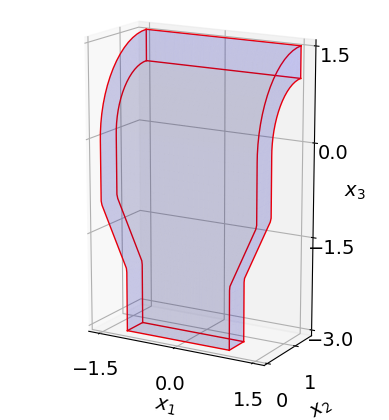

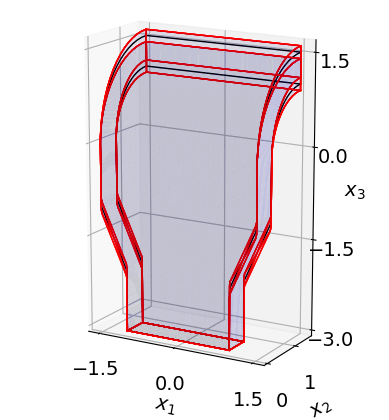

In [5]:

fig = geom.plot_domain([tn.tensor([0.0]),tn.tensor([-0.0]),tn.tensor([0.0])],[(0,1),(0,1),(0.0,1)],surface_color='blue', wireframe = False,alpha=0.1,n=64)
fig.gca().set_xlabel(r'$x_1$', fontsize=14)
fig.gca().set_ylabel(r'$x_2$', fontsize=14)
fig.gca().set_zlabel(r'$x_3$', fontsize=14)
fig.gca().view_init(15, -60)
fig.gca().zaxis.set_rotate_label(False)
fig.gca().set_xticks([-1.5, 0, 1.5])
fig.gca().set_yticks([0,1])
fig.gca().set_zticks([-3,-1.5,0,1.5])
fig.gca().tick_params(axis='both', labelsize=14)
fig.gca().set_box_aspect(aspect = (3,1.5,4.5))

fig = geom.plot_domain([tn.tensor([0.0]), tn.tensor([-0.0]), tn.tensor([0.0])],[(0,1),(0,1),(0.0,1)],surface_color=None, wireframe = False, alpha = 0.1, n = 64, frame_color = 'k')
geom.plot_domain([tn.tensor([Basis_param[0].interval[0]]),tn.tensor([Basis_param[1].interval[0]]), tn.tensor([Basis_param[2].interval[0]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[0]]),tn.tensor([Basis_param[1].interval[0]]), tn.tensor([Basis_param[2].interval[1]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[0]]),tn.tensor([Basis_param[1].interval[1]]), tn.tensor([Basis_param[2].interval[0]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[0]]),tn.tensor([Basis_param[1].interval[1]]), tn.tensor([Basis_param[2].interval[1]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[1]]),tn.tensor([Basis_param[1].interval[0]]), tn.tensor([Basis_param[2].interval[0]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[1]]),tn.tensor([Basis_param[1].interval[0]]), tn.tensor([Basis_param[2].interval[1]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[1]]),tn.tensor([Basis_param[1].interval[1]]), tn.tensor([Basis_param[2].interval[0]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[1]]),tn.tensor([Basis_param[1].interval[1]]), tn.tensor([Basis_param[2].interval[1]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
fig.gca().set_xlabel(r'$x_1$', fontsize=14)
fig.gca().set_ylabel(r'$x_2$', fontsize=14)
fig.gca().set_zlabel(r'$x_3$', fontsize=14)
fig.gca().view_init(15, -60)
fig.gca().zaxis.set_rotate_label(False)
fig.gca().set_xticks([-1.5, 0, 1.5])
fig.gca().set_yticks([0,1])
fig.gca().set_zticks([-3,-1.5,0,1.5])
fig.gca().tick_params(axis='both', labelsize=14)
fig.gca().set_box_aspect(aspect = (3,1.5,4.5))


Construct the stiffness and mass matrix for the entire parameter grid in the TT format.

In [6]:
tme = datetime.datetime.now() 
Mass_tt = geom.mass_interp(Basis, eps=1e-12)
tme = datetime.datetime.now() -tme
print('Time mass matrix ',tme.total_seconds())

tme = datetime.datetime.now() 
Stt = geom.stiffness_interp(Basis, eps = 1e-12, func=None, func_reference = None, qtt = False, verb=False)
tme = datetime.datetime.now() -tme
print('Time stiffness matrix ',tme.total_seconds())

Time mass matrix  0.029582
Time stiffness matrix  0.712258


Get the boundary/interior projection operators.

In [7]:
Pin_tt,Pbd_tt = tt_iga.projectors.get_projectors(N,[[0,0],[0,0],[0,0]])
Pbd_tt = (1/N[2]) * Pbd_tt

Pin_tt = Pin_tt ** tntt.eye([nl]*3)
Pbd_tt = Pbd_tt ** tntt.eye([nl]*3)

Compute the excitation on the bottom port in TT format. 
The tensor is extended using Kronecker product since the excitation does not change with the parameters.
The boundary projectpor is applied to let only the desired dofs nonzero.

In [8]:
f_tt = tntt.zeros(Stt.N)

excitation_dofs = tt_iga.Function(Basis).interpolate(lambda t: tn.sin(t[:,0]*np.pi)*tn.sin(t[:,1]*np.pi))
tmp = tn.zeros(N)
tmp[:,:,0] = excitation_dofs[:,:,0].full()
g_tt = Pbd_tt@ (tntt.TT(tmp) ** tntt.ones([nl]*3))

Compute the system matrix and include the boundary adaptation.

In [9]:
k = 49 

eps_solver = 1e-7
M_tt = (Pin_tt@(Stt-k*Mass_tt)+Pbd_tt).round(1e-12)
rhs_tt = (Pbd_tt @ g_tt).round(1e-12)

M_tt = M_tt.round(1e-11)

Solve the problem (can solve on GPU if one is available) and report ranks, times, memory consumption, etc.

In [10]:
cuda = True
tme_amen = datetime.datetime.now() 
if cuda and tn.cuda.is_available():
    print('Solving in TT (GPU)...')
    dofs_tt = tntt.solvers.amen_solve(M_tt.cuda(), rhs_tt.cuda(), x0 = None, eps = eps_solver, nswp=40, kickrank=2, verbose=True, preconditioner = 'c', local_iterations=48, resets=10).cpu()
else:
    print('Solving in TT (CPU)...')
    dofs_tt = tntt.solvers.amen_solve(M_tt, rhs_tt, x0 = tntt.ones(rhs_tt.N), eps = eps_solver, nswp=40, kickrank=4, verbose=False, preconditioner = 'c', local_iterations=24, resets=10)
tme_amen = (datetime.datetime.now() -tme_amen).total_seconds() 

print('',flush=True)
print('Time system solve in TT :',tme_amen)
print('Relative residual       :', (M_tt@dofs_tt-rhs_tt).norm()/rhs_tt.norm())
print('N                       :',N)
print('Rank Mtt                :',M_tt.R)
print('Rank rhstt              :',rhs_tt.R)
print('Rank solution           :',dofs_tt.R)
print('size stiff              :',tntt.numel(Stt)*8/1e6,' MB')
print('size mass               :',tntt.numel(Mass_tt)*8/1e6,' MB')
print('size system mat         :',tntt.numel(M_tt)*8/1e6,' MB')
print('size rhstt              :',tntt.numel(rhs_tt)*8/1e6,' MB')
print('size solution           :',tntt.numel(dofs_tt)*8/1e6,' MB, one full solution: ',np.prod(N)*8/1e6,' MB')



Solving in TT (CPU)...

Time system solve in TT : 10.495306
Relative residual       : tensor(2.9370e-08)
N                       : [40, 40, 96]
Rank Mtt                : [1, 6, 20, 11, 6, 6, 1]
Rank rhstt              : [1, 1, 1, 1, 1, 1, 1]
Rank solution           : [1, 40, 53, 53, 53, 8, 1]
size stiff              : 21.943296  MB
size mass               : 0.638464  MB
size system mat         : 17.888256  MB
size rhstt              : 0.0016  MB
size solution           : 3.055936  MB, one full solution:  1.2288  MB


Plot the solution in the reference domain for $(y_1,y_2,y_3)\in[0,1]\times\{0.5\}\times[0,1]$ and $\theta_1=\theta_2=\theta_3=0$.

/home/yonnss/anaconda3/envs/pytorch_cpu/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484746322/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0, 0.5, '$y_3$')

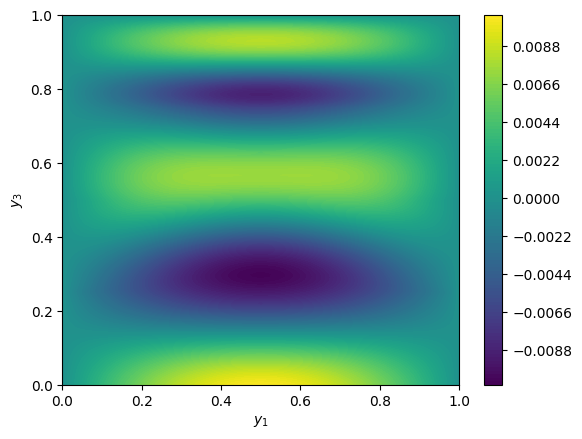

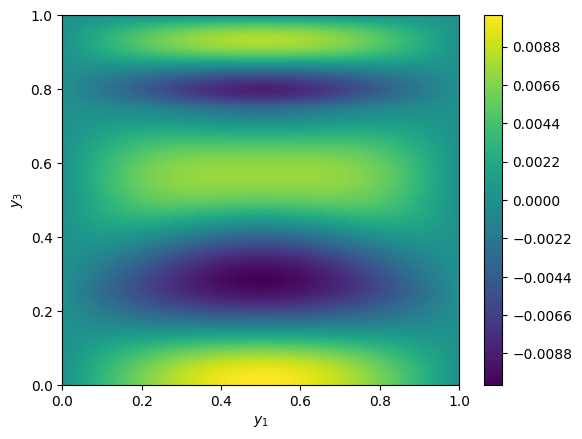

In [11]:
fspace = tt_iga.Function(Basis+Basis_param)
fspace.dofs = dofs_tt

fval = fspace([tn.linspace(0,1,128),tn.tensor([0.5]),tn.linspace(0,1,128),tn.tensor([-0.1]),tn.tensor([-0.1]),tn.tensor([-0.1])])
y1, y3 = tn.meshgrid(tn.linspace(0,1,128),tn.linspace(0,1,128))

plt.figure()
plt.contourf(y1, y3, fval.numpy().squeeze(), levels = 128)
plt.colorbar()
plt.xlabel(r'$y_1$')
plt.ylabel(r'$y_3$')

fval = fspace([tn.linspace(0,1,128),tn.tensor([0.5]),tn.linspace(0,1,128),tn.tensor([0.1]),tn.tensor([0.1]),tn.tensor([0.1])])

plt.figure()
plt.contourf(y1, y3, fval.numpy().squeeze(), levels = 128)
plt.colorbar()
plt.xlabel(r'$y_1$')
plt.ylabel(r'$y_3$')


Plot the domain and the solution in the physical domain for $(y_1,y_2,y_3)\in[0,1]\times\{0.5\}\times[0,1]$ and $\theta_1=\theta_2=\theta_3=0$.

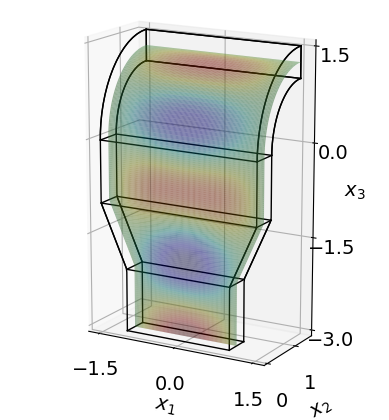

In [12]:
fval = fspace([tn.linspace(0,1,128),tn.tensor([0.5]),tn.linspace(0,1,128),tn.tensor([0.0]),tn.tensor([0.0]),tn.tensor([0.0])])
x,y,z =  geom([tn.linspace(0,1,128),tn.tensor([0.5]),tn.linspace(0,1,128),tn.tensor([0.0]),tn.tensor([0.0]),tn.tensor([0.0])])

fig = geom.plot_domain([tn.tensor([0.0])]*3,[(0,1),(0,1),(0.0,1)],surface_color=None, wireframe = False,frame_color='k',n = 64)
geom.plot_domain([tn.tensor([0.0])]*3,[(0,1),(0,1),(0.25,0.5)],fig=fig,surface_color=None, wireframe = False,frame_color='k',n = 64)
geom.plot_domain([tn.tensor([0.0])]*3,[(0,1),(0,1),(0.75,1)],fig=fig,surface_color=None, wireframe = False,frame_color='k',n = 64)

ax = fig.gca()
C = fval.numpy().squeeze()
norm = matplotlib.colors.Normalize(vmin=C.min(),vmax=C.max())
C = plt.cm.jet(norm(C))
C[:,:,-1] = 1
ax.plot_surface(x.numpy().squeeze(), y.numpy().squeeze(), z.numpy().squeeze(), edgecolors=None, linewidth=0, facecolors = C, antialiased=True, rcount=256, ccount=256, alpha=0.5)
fig.gca().set_xlabel(r'$x_1$', fontsize=14)
fig.gca().set_ylabel(r'$x_2$', fontsize=14)
fig.gca().set_zlabel(r'$x_3$', fontsize=14)
fig.gca().view_init(15, -60)
fig.gca().zaxis.set_rotate_label(False)
fig.gca().set_xticks([-1.5, 0, 1.5])
fig.gca().set_yticks([0,1])
fig.gca().set_zticks([-3,-1.5,0,1.5])
fig.gca().tick_params(axis='both', labelsize=14)
fig.gca().set_box_aspect(aspect = (3,1.5,4.5))


Generate some measurements for the inverse problem.
The measurements correspond to $\theta_1=\theta_2=\theta_3=$ and are taken at $(y_1,y_2,y_3) \in \{0.25,0.5,0.75\} \times \{0.25,0.5,0.75\} \times \{0.75\}$.

[[-7.50000000e-01 -7.50000000e-01 -7.50000000e-01]
 [ 6.29408011e-17  6.29408011e-17  6.29408011e-17]
 [ 7.50000000e-01  7.50000000e-01  7.50000000e-01]]
[[0.125 0.25  0.375]
 [0.125 0.25  0.375]
 [0.125 0.25  0.375]]
[[1.74831562e-17 2.11796332e-17 2.48761101e-17]
 [1.74831562e-17 2.11796332e-17 2.48761101e-17]
 [1.74831562e-17 2.11796332e-17 2.48761101e-17]]
0.007627828271953092 0.0007646543592104083


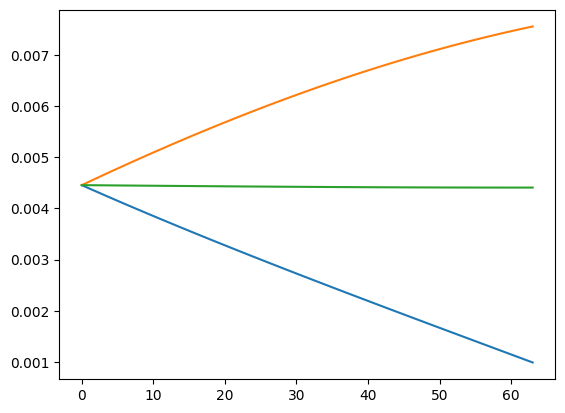

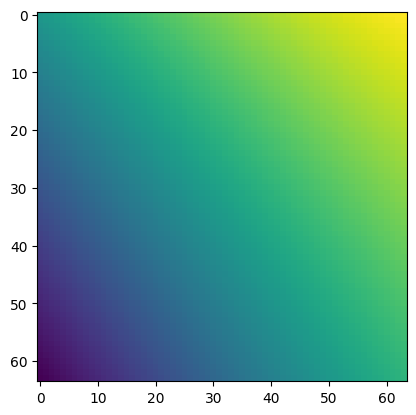

In [13]:
x1 ,x2 , x3 = geom([tn.tensor([0.25, 0.5, 0.75]), tn.tensor([0.25, 0.5, 0.75]), tn.tensor([0.75])]+3*[tn.tensor([0])])
print(x1.numpy().squeeze())
print(x2.numpy().squeeze())
print(x3.numpy().squeeze())
fval = fspace([tn.tensor([0.25, 0.5, 0.75]), tn.tensor([0.25, 0.5, 0.75]), tn.tensor([0.75])]+3*[tn.tensor([0])]).numpy().squeeze()

import pickle
with open('wg_measurement.ipynb', 'wb') as f:
    pickle.dump({'meas' : fval}, f)

fvals = fspace([tn.tensor([0.5])]*3+[tn.linspace(b.interval[0],b.interval[1],64) for b in Basis_param]).numpy().squeeze()

print(fvals.max(),fvals.min())

plt.figure()
plt.plot(fvals[:,0,0])
plt.plot(fvals[0,:,0])
plt.plot(fvals[0,0,:])

plt.figure()
plt.imshow(fvals[:,:,-1])